# Dimension reduction challenge

We are given a three-dimensional time series data. Our task is to reduce the three-dimensional representation into a one-dimensional time series such that the four different metastable states are easy separable.

We begin by preparing the data. We define a method to load the data and whiten it using PCA whitening, i.e. we keep the dimensions of the input, but decorrelate the three components. Additionaly, we scale the data to \[0, 1] as our model will use ReLUs so that we only work with positive values.

In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale

def load_data():
    with np.load("/content/drive/My Drive/dimredux-challenge-01-data.npz") as fh:
        train_x = fh["data_x"]
        valid_x = fh["validation_x"]
        valid_y = fh["validation_y"]

    train_x = whiten(train_x)
    valid_x = whiten(valid_x)

    return train_x, valid_x, valid_y


def whiten(data):
    output = data.astype(np.float32)
    # Mean-free
    output = output - np.mean(output, axis=0)
    # Whiten, scale to [0, 1]
    return minmax_scale(PCA(whiten=True).fit_transform(output))

Next, we define TimeLaggedDataSet class that we will later use with PyTorch DataLoader.

In [5]:
class TimeLaggedDataSet():
    def __init__(self, data_x, tau=0):
        # Shift data by tau steps
        self.data_x = data_x[:-tau] if tau > 0 else data_x
        self.data_y = data_x[tau:] if tau > 0 else data_x

    def __getitem__(self, key):        # why do we need this?
        return self.data_x[key], self.data_y[key]

    def __len__(self):            # and this?
        return self.data_x.shape[0]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


We chose the network structure as described in the [TAE paper](https://arxiv.org/pdf/1710.11239.pdf) for the case when the bottleneck of the autoencoder has dimension of 1:

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
 
        self.e1 = nn.Linear(3, 200) 
        self.e2 = nn.Linear(200, 100)
        self.e3 = nn.Linear(100, 1)

        self.d1 = nn.Linear(1, 100)
        self.d2 = nn.Linear(100, 200)
        self.d3 = nn.Linear(200, 3)

    def forward(self, x, decode=True):
        x = F.dropout(F.leaky_relu(self.e1(x), inplace=True), training=self.training)
        x = F.dropout(F.leaky_relu(self.e2(x), inplace=True), training=self.training)
        x = self.e3(x)

        if decode:
            x = F.dropout(F.leaky_relu(self.d1(x), inplace=True), training=self.training)
            x = F.dropout(F.leaky_relu(self.d2(x), inplace=True), training=self.training)
            x = self.d3(x)

        return x

We next define the method that we'll use for training. It performs one pass through the entire data set.

In [7]:
def train(net, loader, optimizer, criterion, epoch, log_interval=100):
    net.train()
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()

        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                   epoch, batch_idx * len(data), 
                   len(loader.dataset),
                   100. * batch_idx / len(loader), 
                   loss.item()))

And another method that applies the given model to the input, note that we drop the decoder part for evaluation.

In [8]:
def eval(net, loader):
    net.eval()
    batch_size = loader.batch_size
    prediction = np.zeros(len(loader.dataset))
    with torch.no_grad():
        for i, (data, _) in enumerate(loader):
            output = net(data, decode=False)
            prediction[i*batch_size:i*batch_size+len(output):] = output.reshape((-1,))    # what is this?

    return prediction

We'll be using k-means clustering:

In [9]:
from sklearn.cluster import KMeans

def clusterize(data):
    return KMeans(n_clusters=4).fit(data.reshape((-1, 1))).labels_

To measure the accuracy, we have to test all combinations:

In [10]:
from itertools import permutations

def accuracy(prediction, validation, labels=[0, 1, 2, 3]):
    acc = []
    
    for permutation in permutations(labels):
        permutation_validation = np.zeros_like(validation)
        for idx, label in enumerate(labels):
            permutation_validation[validation == label] = permutation[idx]     # what??

        difference = prediction - permutation_validation
        acc.append(1 - (np.count_nonzero(difference) / len(difference)))
        
    return np.max(acc)

Now that we have all the pieces we can train our Autoencoder.

In [11]:
BATCH_SIZE = 100
TAU = 50

In [12]:
train_x, valid_x, valid_y = load_data()
valid_dataset = TimeLaggedDataSet(valid_x, tau=0)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [13]:
net = Autoencoder()
criterion = nn.MSELoss()

For each tau, we perform a full pass and record the accuracy on the validation set. Additionaly, we use a learning rate scheduler that lowers the learning rate at plateu, based on the accuracy on the validation set.

In [14]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

for tau in range(1, TAU + 1):
    dataset = TimeLaggedDataSet(train_x, tau=tau)
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    train(net, train_loader, optimizer, criterion, tau)
    prediction = eval(net, valid_loader)
    clusters = clusterize(prediction)
    acc = accuracy(clusters, valid_y)
    print("Accuracy: ", acc)
    scheduler.step(acc)

Train Epoch: 1 [0/99999 (0%)]	Loss: 0.173595
Train Epoch: 1 [10000/99999 (10%)]	Loss: 0.061275
Train Epoch: 1 [20000/99999 (20%)]	Loss: 0.034621
Train Epoch: 1 [30000/99999 (30%)]	Loss: 0.042462
Train Epoch: 1 [40000/99999 (40%)]	Loss: 0.033258
Train Epoch: 1 [50000/99999 (50%)]	Loss: 0.041390
Train Epoch: 1 [60000/99999 (60%)]	Loss: 0.029431
Train Epoch: 1 [70000/99999 (70%)]	Loss: 0.045264
Train Epoch: 1 [80000/99999 (80%)]	Loss: 0.048039
Train Epoch: 1 [90000/99999 (90%)]	Loss: 0.041641
Accuracy:  0.546
Train Epoch: 2 [0/99998 (0%)]	Loss: 0.048351
Train Epoch: 2 [10000/99998 (10%)]	Loss: 0.047414
Train Epoch: 2 [20000/99998 (20%)]	Loss: 0.032759
Train Epoch: 2 [30000/99998 (30%)]	Loss: 0.040763
Train Epoch: 2 [40000/99998 (40%)]	Loss: 0.033764
Train Epoch: 2 [50000/99998 (50%)]	Loss: 0.040985
Train Epoch: 2 [60000/99998 (60%)]	Loss: 0.026697
Train Epoch: 2 [70000/99998 (70%)]	Loss: 0.041677
Train Epoch: 2 [80000/99998 (80%)]	Loss: 0.051134
Train Epoch: 2 [90000/99998 (90%)]	Loss: 0.

Apply the encoder to the given data set:

In [15]:
dataset = TimeLaggedDataSet(train_x, tau=0)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [16]:
prediction = eval(net, loader)
clusters = clusterize(prediction)

Check the shape and number of points in each cluster:

In [17]:
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([22603, 26602, 25467, 25328]))

Visualize:

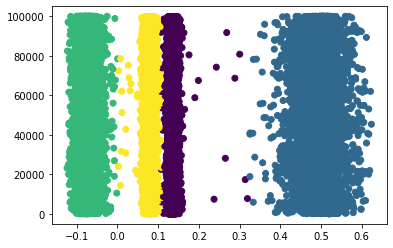

In [18]:
import matplotlib.pyplot as plt

plt.scatter(prediction, range(len(dataset)), c=clusters)
plt.show()

Save the predicted clusters for the submission:

In [19]:
assert clusters.ndim == 1
assert clusters.shape[0] == 100000

np.save("prediction.npy", clusters)

In [20]:
from google.colab import files
files.download('prediction.npy') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>